<h3>Overview</h3>
<p>The objective of this notebook is to utilize Pytorch framework to train an auto-encoder that can learn representations based on three image channels (ECAL, HCAL, and Tracks) for images in the Quark/Gluon jet events dataset.</p>


In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import h5py
import torch
import numpy as np
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader


Quark_Gluon_Dataset is a custom dataset class that is derived from the torch.utils.data.Dataset class in PyTorch.

This class is used to define a dataset that contains images from Quark/Gluon jet events. 

The input images are normalized based on their mean and standard deviation. Normalization ensures that the model is less sensitive to pixel value variations, which helps prevent numerical instabilities and allows the optimizer to converge more quickly.



In [2]:
class Quark_Gluon_Dataset(Dataset):
    def __init__(self, data_size, start):
        with h5py.File('data/quark-gluon_data-set_n139306.hdf5', 'r') as f:
            print(f.keys())
            self.data_size = data_size
            self.x_jets_original = f['X_jets'][start:data_size]
            self.x_jet_data = self.normalize_img()
            self.transform = transforms.Compose([transforms.ToTensor()])



            # Read the data from the dataset into a numpy array
        f.close()
        del f

    def normalize_img(self):
        res = []
        counter = 0
        for x_jet in self.x_jets_original:
            counter+=1

            mean = np.mean(x_jet, axis=(0, 1))
            std = np.std(x_jet, axis=(0, 1))
            x_jet = (x_jet - mean) / std
            # plt.imshow(x_jet)
            # plt.show()
            res.append(x_jet)

        return res

    def __len__(self):
        return len(self.x_jet_data)

    def __getitem__(self, indx):
        img = self.x_jet_data[indx]
        img = self.transform(img)
        return img


Autoencoder is a class that defines an autoencoder neural network architecture.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In the following cell, first, a PyTorch autoencoder model is trained on the Quark/Gluon jet events dataset. Then,the trained model is used to generate reconstructed images for a subset of the testing data. The original and reconstructed images are visualized side by side for comparison

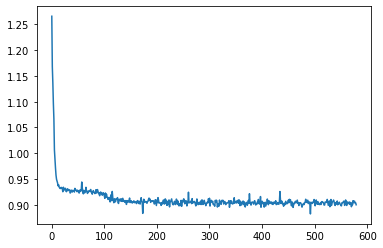

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


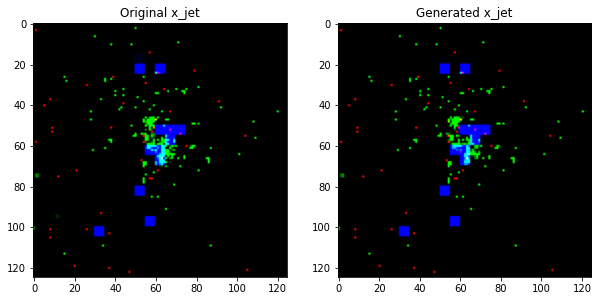

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


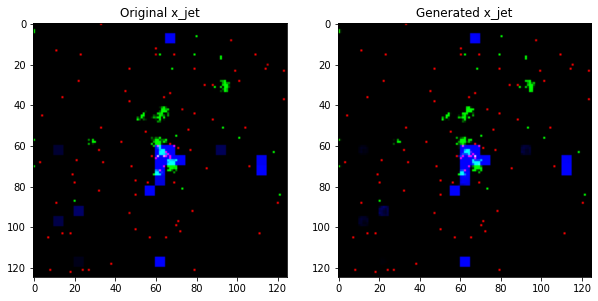

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


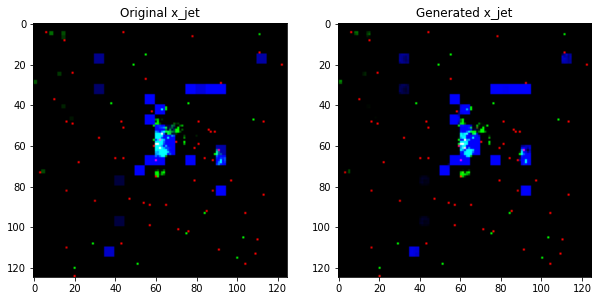

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


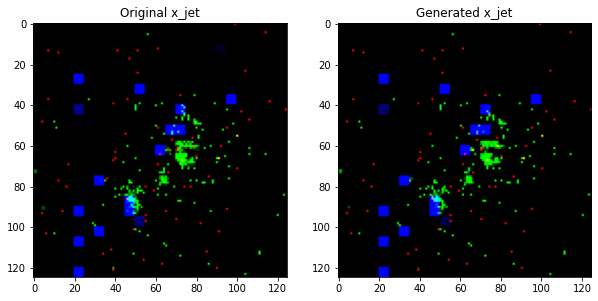

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


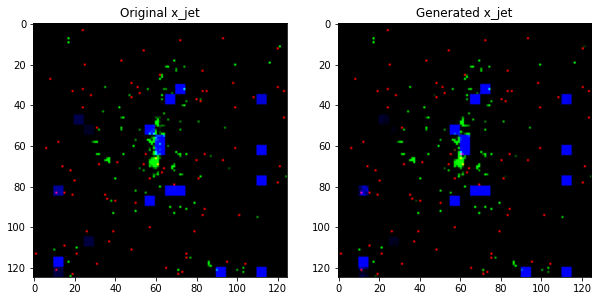

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [4]:

data_size = 900

start=0


q_g_train_data = Quark_Gluon_Dataset(data_size,start)


# dropout_prob = 0.2
# model = Autoencoder(dropout_prob)

model = Autoencoder()
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs = 20
learning_rate =0.01

train_loader = DataLoader(q_g_train_data, batch_size= 32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_list = []
model.train()
for epoch in range(n_epochs):
    for x_jet in train_loader:
        x_jet = x_jet.to(device)
        optimizer.zero_grad()
        output = model(x_jet)
        loss = criterion(output,x_jet)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

plt.plot(loss_list)
plt.show()
model.to('cpu')
model.eval()
q_g_test_data = Quark_Gluon_Dataset(data_size+100,data_size)

for i in range(100):
    x_jet = q_g_test_data[i]
    #x_jet = x_jet.to('cpu')
    output = model(x_jet.unsqueeze(0))
    print('test')

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

    # Display the first image in the first subplot
    ax1.imshow(x_jet.detach().permute((2, 1, 0)))
    ax1.set_title("Original x_jet")

    # Display the second image in the second subplot
    ax2.imshow(output.squeeze(0).detach().permute((2, 1, 0)))
    ax2.set_title("Generated x_jet")

    plt.savefig('results/img'+str(i)+'.png')

    # Show the plot
    if i < 5:
        plt.show()

